In [65]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# All skl imports go here
from sklearn import tree   # Decision Trees
from sklearn import svm    # svm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import sklearn as skl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

In [3]:
# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [4]:
# Perform pre-processing PCA on the training set
def perform_pca(dataset, target_variance):
    pca = PCA(n_components= target_variance)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced

In [42]:
TARGET_EXPLAINED_VARIANCE = 0.999999

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_redced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

768 components for training


In [56]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()


# K-Folds Cross Validation

In [66]:

def k_folds_x_val(model, X, y, k =  5): 
    results = cross_validate(model, X, y, cv=k, scoring=["accuracy"])
    mean_accuracy = results['test_accuracy'].mean()
    print(f"Mean Accuracy: {mean_accuracy}")
    return mean_accuracy, 

def get_cmat(model, X, y):
    y_pred = model.predict(X)
    return confusion_matrix(y, y_pred, normalize="pred")

def get_metrics(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred), f1_score(y, y_pred, average="weighted")

# Grid Search Hyperparameter Optimization

In [33]:
def objective(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return metrics.accuracy_score(Y_test, Y_pred)

def gridSearchHPO(model, search_space):
    grid_search = GridSearchCV(estimator=model, 
                                param_grid=search_space, 
                                scoring=objective,
                                cv=5,
                                n_jobs=-1) # -1 means max amount
    grid_search.fit(X_train, Y_train)
    return grid_search

# Decision Trees

In [8]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    splitter = 'best',
    max_depth = 5
)

In [9]:
k_folds_x_val(decision_tree_model)

Performed 10-fold cross validation
Average accuracy 0.46338888888888896
Average Kappa 0.22733008013902026


In [34]:
# ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter']
gridsearch = gridSearchHPO(decision_tree_model, search_space={'max_depth':[8, 32, 64, None], 'max_features':[8, 32, 128, 512], 'min_samples_leaf':[1, 2, 3], 'min_samples_split':[16, 64, 256]})

c:\Users\techt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [35]:
gridsearch.best_params_

{'max_depth': 8,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 16}

[Text(0.5, 0.9166666666666666, 'x[2] <= -0.23\nentropy = 2.272\nsamples = 16000\nvalue = [4666, 5362, 1304, 2159, 1937, 572]'),
 Text(0.25, 0.75, 'x[3] <= -0.747\nentropy = 2.131\nsamples = 7717\nvalue = [1531, 3666, 810, 711, 677, 322]'),
 Text(0.125, 0.5833333333333334, 'x[5] <= 2.122\nentropy = 2.287\nsamples = 3484\nvalue = [1079, 1070, 249, 495, 451, 140]'),
 Text(0.0625, 0.4166666666666667, 'x[0] <= -6.003\nentropy = 2.299\nsamples = 2709\nvalue = [940, 653, 169, 436, 394, 117]'),
 Text(0.03125, 0.25, 'x[15] <= 0.01\nentropy = 2.051\nsamples = 981\nvalue = [470, 77, 35, 196, 163, 40]'),
 Text(0.015625, 0.08333333333333333, 'entropy = 2.161\nsamples = 413\nvalue = [147, 33, 10, 80, 120, 23]'),
 Text(0.046875, 0.08333333333333333, 'entropy = 1.849\nsamples = 568\nvalue = [323, 44, 25, 116, 43, 17]'),
 Text(0.09375, 0.25, 'x[2] <= -2.854\nentropy = 2.309\nsamples = 1728\nvalue = [470, 576, 134, 240, 231, 77]'),
 Text(0.078125, 0.08333333333333333, 'entropy = 2.225\nsamples = 869\nva

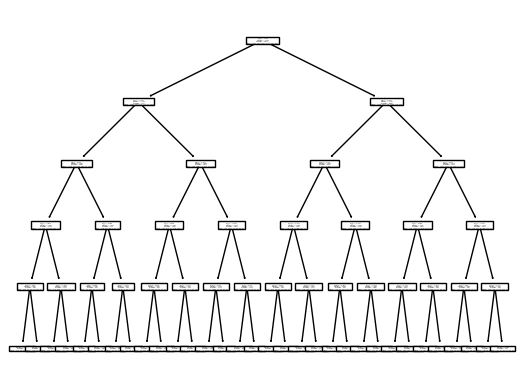

In [10]:
decision_tree_model.fit(X_train_reduced, Y_train)
tree.plot_tree(decision_tree_model)

# SVMs

In [11]:
svm_classifier = svm.SVC(kernel='sigmoid') # 'precomputed', 'linear', 'poly', 'sigmoid', 'rbf'

#Train the model using the training sets
svm_classifier.fit(X_train_reduced, Y_train)

#Predict the response for test dataset
k_folds_x_val(svm_classifier)

Performed 10-fold cross validation
Average accuracy 0.5808888888888889
Average Kappa 0.4227651194469132


# Pytorch Setup

In [19]:
# Pytorch specific constants
from torch.utils.data import TensorDataset, DataLoader
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate
import torch

BATCH_SIZE = 16
LEARNING_RATE = 1e-3

# MLP

In [67]:
X_train_used = X_train_unreduced
X_test_used = X_test_unreduced
X_val_used = X_val_unreduced
X_train_val_used = X_train_val_unreduced
X_val_test_used = X_val_test_unreduced

In [68]:
mlp = MLPClassifier([], 'relu', solver="adam")
mlp.fit(X_train_used, Y_train)

In [ ]:
k_folds_x_val(mlp, X_train_val_used, Y_train_val)

c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Accuracy: 0.5926666666666667


c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


(0.5926666666666667,)

[[0.62820513 0.08091024 0.1036036  0.21265823 0.15521628 0.02439024]
 [0.07466063 0.7300885  0.32432432 0.07848101 0.08396947 0.1097561 ]
 [0.03167421 0.10240202 0.44594595 0.05316456 0.02035623 0.06097561]
 [0.14705882 0.03792668 0.09459459 0.55949367 0.12722646 0.03658537]
 [0.09426848 0.02591656 0.01801802 0.09113924 0.55470738 0.14634146]
 [0.02413273 0.02275601 0.01351351 0.00506329 0.05852417 0.62195122]]


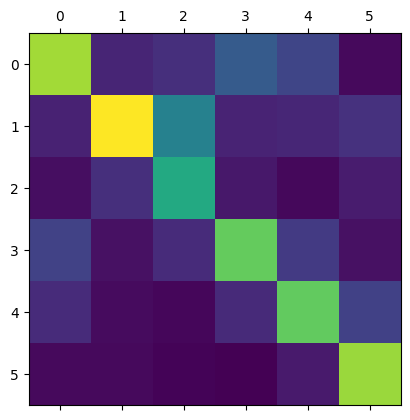

In [ ]:
cmat = get_cmat(mlp, X_val_test_used, Y_val_test)
print(get_metrics(mlp, X_val_test_used, Y_val_test))
plt.matshow(cmat)
plt.show()

In [ ]:
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate

In [ ]:
# For pytorch specifically we should load data to the provided dataloader and dataset classes. 
# This handles the batching for us.

pt_train_set = TensorDataset(torch.Tensor(X_train_used), torch.Tensor(Y_train.to_numpy()).long())
pt_val_set = TensorDataset(torch.Tensor(X_val_used), torch.Tensor(Y_val.to_numpy()).long())
pt_test_set = TensorDataset(torch.Tensor(X_test_used), torch.Tensor(Y_test.to_numpy()).long())
pt_val_test_set = TensorDataset(torch.Tensor(X_val_test_used), torch.Tensor(Y_val_test.to_numpy()).long())

pt_train_loader = DataLoader(
                    dataset=pt_train_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_val_loader = DataLoader(
                    dataset=pt_val_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_test_loader = DataLoader(
                    dataset=pt_test_set, 
                    batch_size=1, 
                    shuffle=True,
                )

pt_val_test_loader = DataLoader(
                    dataset=pt_val_test_set, 
                    batch_size=1, 
                    shuffle=True,
                )

In [ ]:
# Initialize neural network
mlp = NeuralNetwork(X_train_reduced.shape[1], [], NUM_CLASSES)

training_loop(mlp, pt_train_loader, pt_val_loader, 200, LEARNING_RATE)

Epoch 1
train_loss = 1.0092, val_loss = 1.2481
Epoch 2
train_loss = 1.3201, val_loss = 1.1159
Epoch 3
train_loss = 0.8446, val_loss = 1.0524
Epoch 4
train_loss = 0.9545, val_loss = 1.0166
Epoch 5
train_loss = 0.8266, val_loss = 0.9939
Epoch 6
train_loss = 0.8077, val_loss = 0.9811
Epoch 7
train_loss = 0.8742, val_loss = 0.9695
Epoch 8
train_loss = 1.0933, val_loss = 0.9639
Epoch 9
train_loss = 1.4339, val_loss = 0.9621
Epoch 10
train_loss = 0.8331, val_loss = 0.9568
Epoch 11
train_loss = 0.7472, val_loss = 0.9564
Epoch 12
train_loss = 0.9433, val_loss = 0.9509
Epoch 13
train_loss = 0.8333, val_loss = 0.9502
Epoch 14
train_loss = 1.0630, val_loss = 0.9484
Epoch 15
train_loss = 1.1496, val_loss = 0.9468
Epoch 16
train_loss = 0.7268, val_loss = 0.9459
Epoch 17
train_loss = 0.6894, val_loss = 0.9451
Epoch 18
train_loss = 1.1325, val_loss = 0.9453
Epoch 19
train_loss = 0.8886, val_loss = 0.9443
Epoch 20
train_loss = 1.3255, val_loss = 0.9433
Epoch 21
train_loss = 0.6486, val_loss = 0.9418
E

loss = 0.9490
accuracy = 0.6420
f1 = 0.6250
[[0.60973837 0.08557457 0.08290155 0.21705426 0.15243902 0.025     ]
 [0.07267442 0.71760391 0.31088083 0.06718346 0.09146341 0.1125    ]
 [0.03125    0.10268949 0.49740933 0.04134367 0.02134146 0.0875    ]
 [0.15261628 0.04095355 0.07253886 0.57105943 0.11280488 0.0125    ]
 [0.10537791 0.02750611 0.02590674 0.09819121 0.57926829 0.1625    ]
 [0.02834302 0.02567237 0.01036269 0.00516796 0.04268293 0.6       ]]


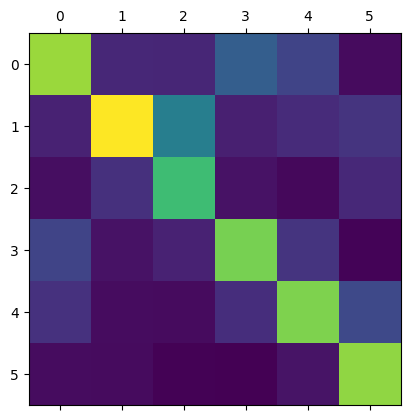

In [ ]:
_, _, _, cmat = evaluate(model=mlp, val_dl=pt_val_test_loader)
print(cmat)
plt.matshow(cmat)
plt.show()